In [1]:
import pandas as pd

In [2]:
cases_total = pd.read_csv('2020-04-15_total.csv', delimiter = ',', header=None).drop([0,2,3], axis=1).drop([0])
cases_total.columns = [n for n in range(len(cases_total.columns))]
for n in range(len(cases_total.columns))[1:]:
    cases_total[n] = pd.to_numeric(cases_total[n])

In [3]:
cases_recov = pd.read_csv('2020-04-15_recov.csv', delimiter = ',', header=None).drop([0,2,3], axis=1).drop([0])
cases_recov.columns = [n for n in range(len(cases_recov.columns))]
for n in range(len(cases_recov.columns))[1:]:
    cases_recov[n] = pd.to_numeric(cases_recov[n])

In [4]:
cases_death = pd.read_csv('2020-04-15_death.csv', delimiter = ',', header=None).drop([0,2,3], axis=1).drop([0])
cases_death.columns = [n for n in range(len(cases_death.columns))]
for n in range(len(cases_death.columns))[1:]:
    cases_death[n] = pd.to_numeric(cases_death[n])

In [5]:
# Agregate by country

cases_total_bc = cases_total.groupby(cases_total[0]).agg('sum')
cases_recov_bc = cases_recov.groupby(cases_recov[0]).agg('sum')
cases_death_bc = cases_death.groupby(cases_death[0]).agg('sum')

In [6]:
"""
Get all countries and shift from outbrake day 0 for each country
"""
single_dfs = []
for i in range(len(cases_total_bc.index)):
    single_row = cases_total_bc.iloc[[i]]
    zero_cols = [ col for col, is_zero in ((single_row == 0).sum() == single_row.shape[0]).items() if is_zero]
    single_row_dropped = single_row.drop(zero_cols, axis=1)
    single_row_dropped.columns = range(single_row_dropped.columns.size)
    single_dfs.append(single_row_dropped)

shifted_df = pd.concat(single_dfs)

shifted_df_transp_total = shifted_df.T
df_transp_recov = cases_recov_bc.T
df_trasp_death = cases_death_bc.T

In [7]:
# Extract Brazil data

countries = ['Brazil']
population = 212559417*0.03

br_total = shifted_df_transp_total[countries].dropna().values[:,0][16:]
br_recov = df_transp_recov[countries][-len(br_total):].values[:,0]
br_death = df_trasp_death[countries][-len(br_total):].values[:,0]

In [8]:
len(br_total), len(br_recov), len(br_death), 

(33, 33, 33)

In [9]:
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# an_array = np.empty((1,DAYS-31))
# an_array[:] = np.NaN
# an_array[0]
# cases_filled = np.concatenate((cases[:,0], an_array[0]))
cases_br = br_total
DAYS = len(cases_br)
START = cases_br[0]
START

151.0

In [11]:
# ODEs
def SIR_model(y, t, beta, gamma):
    S, I, R = y
    
    dS_dt = -beta*S*I
    dI_dt = beta*S*I - gamma*I
    dR_dt = gamma*I
    
    return([dS_dt, dI_dt, dR_dt])

In [12]:
# Initial conditions
S0 = population
I0 = START
R0 = 0.0
beta = 1.7422467656256903e-08
gamma = 0.006165388360591112

# Time vector
tv = np.linspace(0, 200, 200)

# Result
solution = scipy.integrate.odeint(SIR_model, [S0, I0, R0], tv, args=(beta, gamma))
solution = np.array(solution)

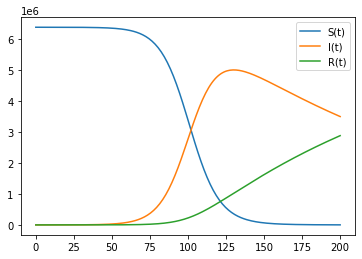

In [13]:
# Plot
plt.figure(figsize=[6,4])
plt.plot(tv, solution[:,0], label="S(t)")
plt.plot(tv, solution[:,1], label="I(t)")
plt.plot(tv, solution[:,2], label="R(t)")
# plt.plot(tv, cases_br, label="cases")
plt.legend()
plt.show()

In [14]:
from symfit import Parameter, variables, Fit, D, ODEModel

In [26]:
sdata = population - br_total
idata = br_total - br_recov - br_death
rdata = br_recov + br_death
tdata = np.linspace(0, len(sdata), len(sdata))

s, i, r, t = variables('s, i, r, t')
beta = Parameter('beta', 2.7174702790581657e-08)
gamma = Parameter('gamma', 0.006165388360590151)
s0 = population

model_dict = {
    D(s, t): -beta*s*i,
    D(i, t): beta*s*i - gamma*i,
    D(r, t): gamma*i,
}

In [27]:
ode_model = ODEModel(model_dict, initial={t: tdata[0], s: sdata[0], i: idata[0], r: rdata[0]})

fit = Fit(ode_model, t=tdata, s=sdata, i=idata, r=rdata)
fit_result = fit.execute()

In [28]:
beta_i = (432/(idata[-2]*sdata[-2])+368/(idata[-6]*sdata[-6]))/2
gamma_i = (20/idata[-2] + 14/idata[-4])/2
print('beta', beta_i, fit_result.value(beta))
print('gamma', gamma_i, fit_result.value(gamma))

beta 3.255630798458789e-09 2.6223324181282322e-08
gamma 0.0008162847736250385 0.006165388360590574


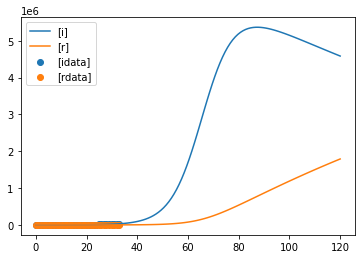

In [33]:
# Generate some data
tvec = np.linspace(0, 120, 120)

i, r, s = ode_model(t=tvec, **fit_result.params)
# plt.plot(tvec, s, label='[s]')
plt.plot(tvec, i, label='[i]')
plt.plot(tvec, r, label='[r]')
plt.scatter(tdata, idata, label='[idata]')
plt.scatter(tdata, rdata, label='[rdata]')
plt.legend()
plt.show()